In [68]:
# ---- Imports ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

import scipy
from scipy.sparse import issparse

from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

from catboost import CatBoostRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import VerboseCallback

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

from tqdm import tqdm

In [69]:
# ---- Load datasets ----

train_df = pd.read_csv('./data/train.csv')



In [ ]:
# ---- FeatureEngineer Class (As Provided) ----
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, current_year=2024, top_n_property_types=15, top_n_amenities=50):
        self.current_year = current_year  # in case data was collected in different year

        # mapping response times to numerical values
        self.response_time_mapping = {
            'within an hour': 4,
            'within a few hours': 3,
            'within a day': 2,
            'a few days or more': 1
        }

        self.top_n_property_types = top_n_property_types
        self.top_property_types = []

        # room type mapping
        self.room_type_mapping = {
            'Entire home/apt': 3,
            'Private room': 2,
            'Hotel room': 1,
            'Shared room': 0
        }

        self.top_n_amenities = top_n_amenities
        self.top_amenities = []
        self.mlb = MultiLabelBinarizer() 

        self.verification_types = []

    def clean_amenities(self, amenities_series):
        # Remove brackets and quotes, then split by comma
        cleaned_amenities = amenities_series.apply(
            lambda x: [amenity.strip().strip("'").strip('"') 
                    for amenity in x.strip('[]').split(',')]
        )
        return cleaned_amenities
    
    def clean_host_verifications(self, verifications_series):
        cleaned_verifications = verifications_series.apply(
            lambda x: [verification.strip().strip("'").strip('"') 
                    for verification in x.strip('[]').split(',')]
        )
        return cleaned_verifications

    def fit(self, X, y=None):
        # simplify property type using regex
        property_types_simplified = X['property_type'].str.replace(
            r'^(Entire |Private |Shared |Room in )', '', regex=True
        )
        # isolate top n property types
        self.top_property_types = property_types_simplified.value_counts().nlargest(self.top_n_property_types).index.tolist()

        # Process amenities
        amenities_list = self.clean_amenities(X['amenities'].fillna(''))
        amenities = amenities_list.explode()
        self.top_amenities = amenities.value_counts().nlargest(self.top_n_amenities).index.tolist()

        # Initialize MultiLabelBinarizer with top amenities
        self.mlb = MultiLabelBinarizer(classes=self.top_amenities)
        self.mlb.fit(amenities_list.apply(lambda x: [i for i in x if i in self.top_amenities]))

        if 'host_verifications' in X.columns:
            cleaned_verifications = self.clean_host_verifications(X['host_verifications'])
            unique_verifications = cleaned_verifications.explode().unique()
            self.verification_types = [v for v in unique_verifications if v]  # Exclude empty strings

        return self
    
    def transform(self, X):
        """
        Applies feature engineering transformations to the DataFrame.

        Parameters:
        - X (pd.DataFrame): The input DataFrame.

        Returns:
        - X (pd.DataFrame): The transformed DataFrame.
        """
        X = X.copy()

        # 1. Encode 'host_is_superhost' as binary
        if 'host_is_superhost' in X.columns:
            X['host_is_superhost_encoded'] = X['host_is_superhost'].astype(bool).astype(int)
        else:
            X['host_is_superhost_encoded'] = 0  # Default value if column is missing

        # 2. Ordinal encode 'host_response_time'
        if 'host_response_time' in X.columns:
            X['host_response_time_encoded'] = X['host_response_time'].map(self.response_time_mapping)
        else:
            X['host_response_time_encoded'] = self.response_time_mapping['a few days or more']  # Default value

        # 3. Encode 'room_type' as ordinal
        if 'room_type' in X.columns:
            X['room_type_encoded'] = X['room_type'].map(self.room_type_mapping)
        else:
            X['room_type_encoded'] = 0  # Default value

        # 4. Convert 'host_since' to 'host_years'
        if 'host_since' in X.columns:
            X['host_since'] = pd.to_datetime(X['host_since'], errors='coerce')
            X['host_years'] = self.current_year - X['host_since'].dt.year
            X['host_years'] = X['host_years'].fillna(0).astype(int)  # Handle NaT
        else:
            X['host_years'] = 0  # Default value

        # 5. Fill missing 'neighbourhood_group_cleansed' with 'Unknown'
        if 'neighbourhood_group_cleansed' in X.columns:
            X['neighbourhood_group_cleansed'] = X['neighbourhood_group_cleansed'].fillna('Unknown')
        else:
            X['neighbourhood_group_cleansed'] = 'Unknown'  # Default value

        # 6. Add 'has_review' feature
        if 'reviews' in X.columns:
            X['has_review'] = X['reviews'].apply(lambda x: 0 if pd.isna(x) or len(str(x).strip()) == 0 else 1)
        else:
            X['has_review'] = 0  # Default value

        # days since last review
        if 'last_review' in X.columns:
            X['last_review'] = pd.to_datetime(X['last_review'], errors='coerce')
            X['days_since_last_review'] = (pd.Timestamp.now() - X['last_review']).dt.days
            X['days_since_last_review'] = X['days_since_last_review'].fillna(0).astype(int)

        # days since first review
        if 'first_review' in X.columns:
            X['first_review'] = pd.to_datetime(X['first_review'], errors='coerce')
            X['days_since_first_review'] = (pd.Timestamp.now() - X['first_review']).dt.days
            X['days_since_first_review'] = X['days_since_first_review'].fillna(0).astype(int)

        # 9. Process 'amenities' and binarize
        amenities_list = self.clean_amenities(X['amenities'].fillna(''))
        X['amenities_simplified'] = amenities_list.apply(lambda x: [i for i in x if i in self.top_amenities])

        # Binarize the amenities
        amenities_binarized = self.mlb.transform(X['amenities_simplified'])
        amenities_df = pd.DataFrame(amenities_binarized, columns=self.mlb.classes_, index=X.index)
        X = pd.concat([X, amenities_df], axis=1)

        # 7. Simplify 'property_type' by removing room type prefixes
        if 'property_type' in X.columns:
            X['property_type_simplified'] = X['property_type'].str.replace(
                r'^(Entire |Private |Shared |Room in )', '', regex=True
            )
        else:
            X['property_type_simplified'] = 'Other'  # Default value

        # 8. Group 'property_type' into top N and 'Other'
        X['property_type_grouped'] = X['property_type_simplified'].apply(
            lambda x: x if x in self.top_property_types else 'Other'
        )

        # 10. Process 'host_verifications' and binarize
        if 'host_verifications' in X.columns:
            cleaned_verifications = self.clean_host_verifications(X['host_verifications'])
            # column for phone, email, work_email
            for verification in self.verification_types:
                X[f'{verification}_verification'] = cleaned_verifications.apply(
                    lambda x: 1 if verification in x else 0
                )
            
        # 11. bathroom shared or not. look at text for word shared. if null then 0
        if 'bathrooms_text' in X.columns:
            X['bathrooms_shared'] = X['bathrooms_text'].fillna('').str.contains('shared').astype(int)
        else:
            X['bathrooms_shared'] = 0

        # bedroom/bathroom ratio
        if 'bedrooms' in X.columns and 'bathrooms' in X.columns:
            X['bed_bath_ratio'] = X['bedrooms'] / X['bathrooms']
            X['bed_bath_ratio'] = X['bed_bath_ratio'].replace([np.inf, -np.inf], np.nan)
            X['bed_bath_ratio'] = X['bed_bath_ratio'].fillna(0)
        
        # 12. Ensure all categorical features are strings
        categorical_features_post = [
            'neighbourhood_group_cleansed',
            'neighbourhood_cleansed', 'property_type_grouped'
        ]
        for col in categorical_features_post:
            X[col] = X[col].astype(str)

        # 13. Drop original columns that have been engineered
        columns_to_drop = [
            'host_is_superhost', 'host_response_time', 'room_type',
            'host_since', 'property_type', 'amenities', 'host_verifications', 'bathrooms_text',
            'last_review', 'first_review', 'reviews'
        ]
        X.drop(columns=[col for col in columns_to_drop if col in X.columns], inplace=True)

        return X

In [74]:
# ---- Feature Engineering and Feature Lists ----

# Instantiate FeatureEngineer
feature_engineer = FeatureEngineer()

# Fit FeatureEngineer on the training data
feature_engineer.fit(X_train := X, y_train := y)  # X_train and y_train are subsets; ensure they are defined appropriately

# Extract amenity feature names
amenity_features = feature_engineer.mlb.classes_.tolist()

# Define updated feature lists
numerical_features = [
    'latitude', 'longitude', 'host_listings_count', 'host_total_listings_count',
    'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'availability_30', 'availability_60',
    'availability_90', 'availability_365', 'minimum_nights', 'maximum_nights',
    'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'host_acceptance_rate',
    'reviews_per_month',
    'host_years',  # Newly added numerical feature
    'days_since_last_review',
    'days_since_first_review',
    'bed_bath_ratio'
] + amenity_features  # Include amenity features

categorical_features = [
    'neighbourhood_group_cleansed',
    'neighbourhood_cleansed',
    'property_type_grouped',                  # Transformed categorical feature
]

binary_features = [
    'has_review',                              # Newly added binary feature
    'bathrooms_shared',                        # Newly added binary feature
    'host_is_superhost_encoded',               # Transformed categorical feature
    'email_verification',
    'phone_verification',
    'work_email_verification',
    'instant_bookable',
    'host_has_profile_pic',
    'has_availability', 
]

# ---- Preprocessing Pipelines ----

# Define preprocessing for numerical data
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical data
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # No encoding since CatBoost handles categorical features natively
])

def bool_to_str(X):
    return X.astype(str)

# Define preprocessing for binary data
binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('bool_to_int', FunctionTransformer(bool_to_str, validate=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features),
    ('binary', binary_pipeline, binary_features)
], remainder='drop')

# ---- Calculate Categorical Feature Indices ----

def calculate_cat_features_indices(numerical, categorical, binary):
    return list(range(len(numerical), len(numerical) + len(categorical) + len(binary)))

cat_features_indices = calculate_cat_features_indices(numerical_features, categorical_features, binary_features)
print("Categorical Feature Indices:", cat_features_indices)

# ---- Full Pipeline Definition ----

pipeline = Pipeline([
    ('feature_engineer', feature_engineer),  # Feature engineering step
    ('preprocessor', preprocessor),          # Preprocessing step
    ('model', CatBoostRegressor(
        learning_rate=0.1,
        iterations=2000,
        depth=6,
        cat_features=cat_features_indices,    # Specify categorical feature indices
        verbose=0
    ))
])

Categorical Feature Indices: [84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]


In [75]:
# Load train data
X = train_df.drop(columns=['price'])
y = train_df['price']

# ---- Split the Data into Training and Testing Sets ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# ---- Fit the Pipeline on the Training Data ----
pipeline.fit(X_train, y_train)

# Define the number of folds for cross-validation
n_splits = 5  # You can adjust this number for quicker testing

# Initialize the K-Fold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)

# Perform cross-validation on the training data
cv_scores = cross_val_score(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    scoring='neg_root_mean_squared_error',  # Use negative RMSE as scoring
    cv=kf,
    n_jobs=-1,
    verbose=1
)

# Convert scores to positive values
cv_rmse_scores = -cv_scores

# Calculate mean and standard deviation of RMSE scores
mean_cv_rmse = np.mean(cv_rmse_scores)
std_cv_rmse = np.std(cv_rmse_scores)

print(f'Cross-Validation RMSE Scores: {cv_rmse_scores}')
print(f'Mean CV RMSE: {mean_cv_rmse:.4f}')
print(f'Standard Deviation of CV RMSE: {std_cv_rmse:.4f}')

# ---- Evaluate the Model on the Test Set ----
# Predict on the test set
y_test_pred = pipeline.predict(X_test)

# Calculate RMSE on the test set
test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
print(f'Test RMSE: {test_rmse:.4f}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   17.6s remaining:   26.4s


Cross-Validation RMSE Scores: [0.72045164 0.76379334 0.72626047 0.72613933 0.74188928]
Mean CV RMSE: 0.7357
Standard Deviation of CV RMSE: 0.0158
Test RMSE: 0.7264


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


In [31]:
%%timeit 

pipeline.fit(X_train, y_train)
y_test_pred = pipeline.predict(X_test)

6.71 s ± 293 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
# ---- Exporting test results ----
test_df = pd.read_csv('./data/test.csv')

# predict
y_test_pred = pipeline.predict(test_df)

# round to nearest integer
y_test_pred = np.round(y_test_pred, 0).astype(int)

# save to csv
test_df['price'] = y_test_pred
test_df[['id', 'price']].to_csv('./data/test_results.csv', index=False)

/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [8]:
# ---- Feature Importance ----
# Function to get feature names from the ColumnTransformer
def get_feature_names(column_transformer):
    feature_names = []

    # Retrieve transformer list
    for name, transformer, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(transformer, 'get_feature_names_out'):
                # If the transformer has get_feature_names_out, use it
                transformed_features = transformer.get_feature_names_out(features)
            else:
                # If not, use the original feature names
                transformed_features = features
            feature_names.extend(transformed_features)
        elif transformer == 'passthrough':
            # Append passthrough features
            feature_names.extend(features)
    return feature_names

# Get feature names from the preprocessor
preprocessor = pipeline.named_steps['preprocessor']
feature_names = get_feature_names(preprocessor)

# Print the total number of features after preprocessing
print(f'Total number of features: {len(feature_names)}')

Total number of features: 284


In [9]:
# Perform permutation importance on the test set
perm_importance = permutation_importance(
    pipeline,
    X_test,
    y_test,
    n_repeats=10,
    random_state=0,
    scoring='neg_root_mean_squared_error'
)

# Get the importance scores
perm_importance_mean = perm_importance.importances_mean

# Create a DataFrame for visualization
perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance_mean
})

# Sort features by importance
perm_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the top 20 most important features
perm_importance_df.head(20)

/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zer

,Feature,Importance
34,minimum_nights,0.300046
6,longitude,0.184847
22,accommodates,0.127065
21,room_type,0.110177
27,amenities,0.098725
5,latitude,0.076565
24,bathrooms_text,0.064363
25,bedrooms,0.047385
2,property_type,0.037617
13,host_total_listings_count,0.033370


In [10]:
# Get the trained model from the pipeline
model = pipeline.named_steps['model']

# Retrieve feature importances from the model
importances = model.feature_importances_

# Create a DataFrame for visualization
import pandas as pd

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the top 20 most important features
feature_importance_df.head(20)

,Feature,Importance
16,minimum_nights,12.286062
274,room_type_encoded_2,8.482890
1,longitude,8.217972
8,accommodates,6.038398
0,latitude,4.117919
2,host_listings_count,3.471751
10,bedrooms,3.447420
3,host_total_listings_count,3.332825
277,bathrooms_shared,3.250070
275,room_type_encoded_3,2.626438


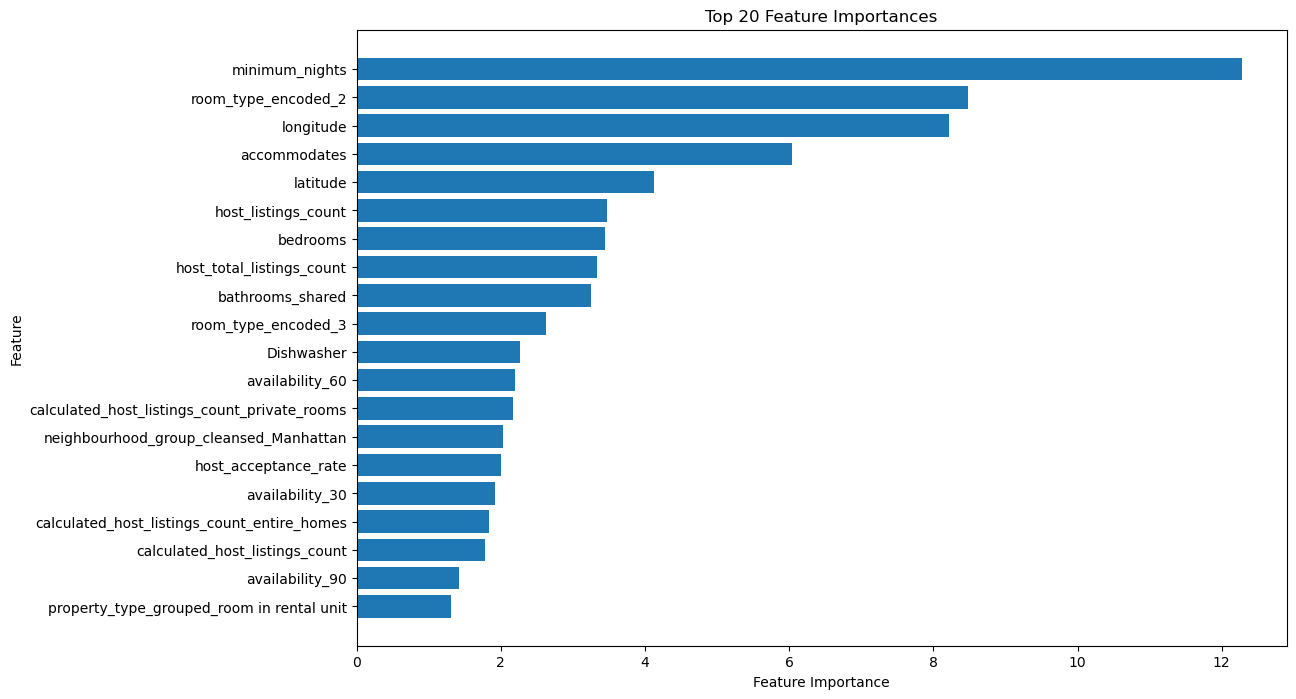

In [11]:
import matplotlib.pyplot as plt

# Plot the top 20 most important features
top_n = 20  # Number of top features to display
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(12, 8))
plt.barh(y=top_features['Feature'][::-1], width=top_features['Importance'][::-1])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importances')
plt.show()

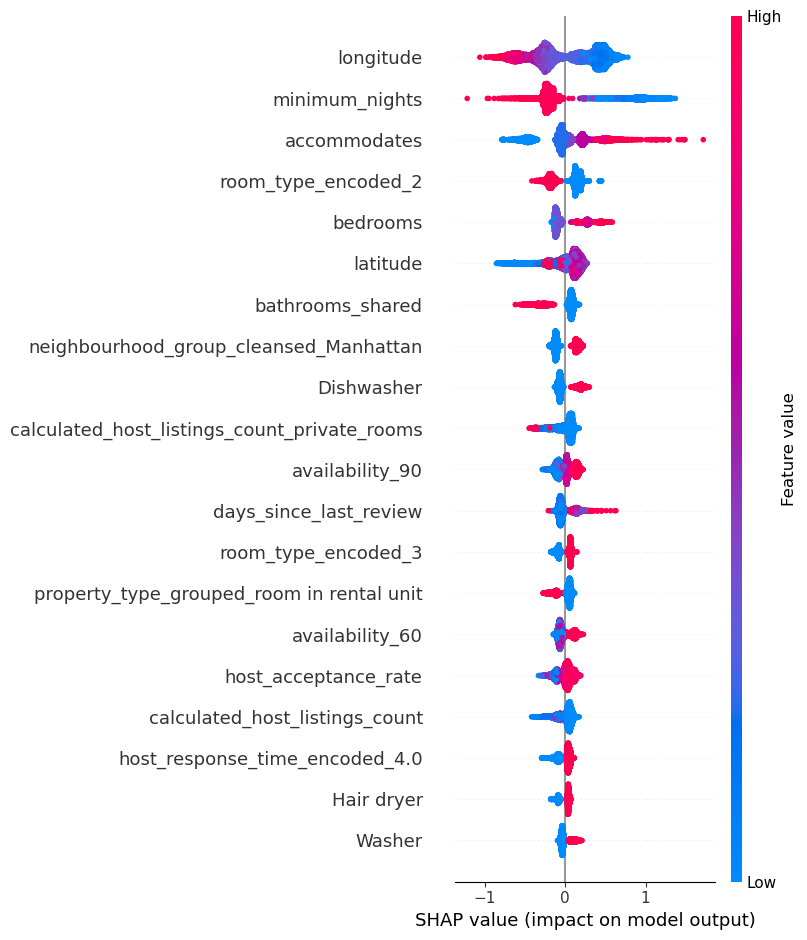

In [12]:
# Apply the FeatureEngineer transformation to the entire dataset
X_train_fe = pipeline.named_steps['feature_engineer'].transform(X_train)

# Apply the preprocessor transformation
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train_fe)

# Convert to dense array if necessary
if isinstance(X_train_transformed, scipy.sparse.spmatrix):
    X_train_transformed = X_train_transformed.toarray()

# Retrieve feature names
def get_feature_names(preprocessor):
    feature_names = []

    for name, transformer, columns in preprocessor.transformers_:
        if transformer == 'drop':
            continue
        elif transformer == 'passthrough':
            feature_names.extend(columns)
        else:
            if isinstance(transformer, Pipeline):
                # Get the last transformer in the pipeline
                transformer = transformer.steps[-1][1]

            if hasattr(transformer, 'get_feature_names_out'):
                # For transformers that support get_feature_names_out
                names = transformer.get_feature_names_out(columns)
            else:
                # Fallback to the original column names
                names = columns

            feature_names.extend(names)

    return feature_names

# Get feature names
feature_names = get_feature_names(pipeline.named_steps['preprocessor'])

# Ensure the number of features match
assert X_train_transformed.shape[1] == len(feature_names), "Mismatch between data and feature names"

# Create DataFrame of transformed features
X_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

# Get the trained model
model = pipeline.named_steps['model']

# Initialize the SHAP TreeExplainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_transformed)

# Plot the SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_transformed_df)

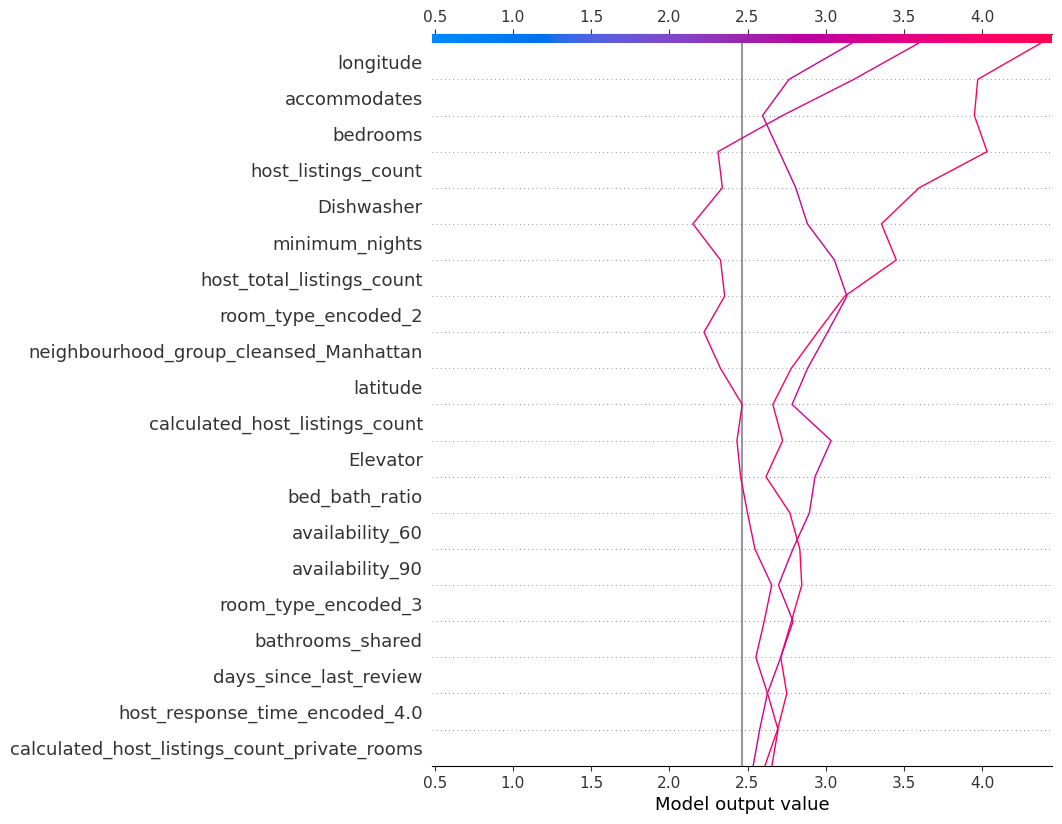

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly select 1,000 observations
n_samples = 1000
random_indices = np.random.choice(X_transformed_df.index, n_samples, replace=False)

random_indices = [0, 1, 2]

# Subset the data and SHAP values
X_subset = X_transformed_df.iloc[random_indices]

if isinstance(shap_values, list):
    # For multiclass classification
    class_index = 0  # Change this to the desired class index
    shap_values_subset = shap_values[class_index][random_indices]
    expected_value = explainer.expected_value[class_index]
else:
    # For regression or binary classification
    shap_values_subset = shap_values[random_indices]
    expected_value = explainer.expected_value

# Plot the SHAP decision plot for the random subset
plt.figure(figsize=(12, 8))
shap.decision_plot(expected_value, shap_values_subset, X_subset)

In [14]:
# ---- Model Info ----
# get the names of featuers
feature_names = get_feature_names(pipeline.named_steps['preprocessor'])
# print number
print(f"Feature names: {feature_names}")
print(f"Number of features: {len(feature_names)}")

print()

# check which featues were added during preprocessing
added_features = set(feature_names) - set(train_df.columns)
print(f"Added features: {added_features}")
print(f"Number of added features: {len(added_features)}")

# features in the original data that were not used in the model
unused_features = set(train_df.columns) - set(feature_names)
print(f"Unused features: {unused_features}")
print(f"Number of unused features: {len(unused_features)}")

Feature names: ['latitude', 'longitude', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'host_acceptance_rate', 'reviews_per_month', 'host_years', 'days_since_last_review', 'days_since_first_review', 'has_review', 'bed_bath_ratio', 'Smoke alarm', 'Wifi', 'Carbon monoxide alarm', 'Kitchen', 'Hot water', 'Essentials', 'Hangers', 'Hair dryer', 'Iron', 'Refrigerator', 'Dishes and silverware', 'Air cond

In [15]:
# 

In [16]:
# -- SHAP Value Interpretation --
# how many shap importance values are greater than 0.01
n_features = (np.abs(shap_values).mean(0) > 0.05).sum()
print(f'Number of features with |SHAP| > 0.01: {n_features}')

Number of features with |SHAP| > 0.01: 24


In [17]:
# drop features with low importance
mean_shap_values = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({'Feature': feature_names, 'Importance': mean_shap_values})

# Sort by importance
shap_df.sort_values(by='Importance', ascending=True, inplace=True)

# Filter features below the threshold
threshold = 0.01  # Adjust threshold
features_to_keep = shap_df[shap_df['Importance'] > threshold]['Feature'].tolist()

print(f'Number of features to keep: {len(features_to_keep) / len(feature_names) * 100:.2f}%')
print(f'Features to keep: {features_to_keep}')

Number of features to keep: 20.77%
Features to keep: ['First aid kit', 'Cooking basics', 'instant_bookable', 'Coffee', 'Hot water', 'neighbourhood_group_cleansed_Brooklyn', 'property_type_grouped_hotel', 'Coffee maker', 'work_email_verification', 'neighbourhood_cleansed_Williamsburg', 'review_scores_accuracy', 'property_type_grouped_rental unit', 'Microwave', 'review_scores_location', 'reviews_per_month', 'availability_365', 'number_of_reviews', 'Self check-in', 'Dedicated workspace', 'host_is_superhost_encoded', 'maximum_nights', 'number_of_reviews_ltm', 'Pets allowed', 'Wine glasses', 'days_since_first_review', 'Shampoo', 'host_years', 'review_scores_cleanliness', 'bed_bath_ratio', 'review_scores_value', 'Lock on bedroom door', 'Elevator', 'beds', 'bathrooms', 'calculated_host_listings_count_entire_homes', 'host_total_listings_count', 'availability_30', 'host_listings_count', 'review_scores_rating', 'Washer', 'Hair dryer', 'host_response_time_encoded_4.0', 'calculated_host_listings_c

In [18]:
# feature importance of features starting with 'bathroom_text'
bathroom_text_features = [feature for feature in feature_names if feature.startswith('bathrooms')]
bathroom_text_importance = shap_df[shap_df['Feature'].isin(bathroom_text_features)]
print(f"Bathroom text features importance: {bathroom_text_importance}")

Bathroom text features importance:               Feature  Importance
9           bathrooms    0.044432
277  bathrooms_shared    0.134630


In [19]:
# modify the pipeline to include only the important features
class FeatureFilter(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_keep):
        self.features_to_keep = features_to_keep

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        full_feature_names = get_feature_names(preprocessor)
        # is X sparse?
        # to pandas dataframe from numpy
        X = pd.DataFrame(X, columns=full_feature_names)

        # DEBUG: how many features now
        print(f'Number of features before filtering: {X.shape[1]}')
        # print head
        # see if features have invalid names feature_names must be string, and may not contain [, ] or <

        return X[self.features_to_keep]
    
pipeline_with_filter = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('feature_filter', FeatureFilter(features_to_keep)),  # Filter selected features
    ('model', CatBoostRegressor(
        learning_rate=0.1,
        iterations=1000,
        depth=6,
        verbose=0
    ))
])

# retrain
pipeline_with_filter.fit(X_train, y_train)

# evaluate
y_test_pred_filtered = pipeline_with_filter.predict(X_test)
test_rmse_filtered = np.sqrt(np.mean((y_test - y_test_pred_filtered) ** 2))
print(f'Test RMSE after feature filtering: {test_rmse_filtered:.4f}')

# print number of features
print(f"Number of features: {len(features_to_keep)}")

Number of features before filtering: 284
Number of features before filtering: 284
Test RMSE after feature filtering: 0.7252
Number of features: 59


/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [80]:
# ---- Hyperparameter Tuning ----

# Define the parameter search space with improved ranges for CatBoost
param_space = {
    'model__iterations': Integer(1000, 5000),
    'model__depth': Integer(2, 15),
    'model__learning_rate': Real(0.005, 0.4, prior='log-uniform'),
    'model__subsample': Real(0.6, 1.0, prior='uniform'),
    'model__l2_leaf_reg': Real(1.0, 10.0, prior='uniform'),
    'model__model_size_reg': Real(0.0, 1.0, prior='uniform'),
    'model__random_strength': Real(1.0, 10.0, prior='uniform'),
    'model__bagging_temperature': Real(0.0, 1.0, prior='uniform'),
    'model__min_data_in_leaf': Integer(1, 10),
    # Optional additional hyperparameters
    'model__border_count': Integer(32, 255),
    #'model__boosting_type': Categorical(['Ordered', 'Plain']),
}

# Initialize the CatBoostRegressor with early stopping parameters
catboost_model = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    thread_count=-1,
    random_state=0,
    cat_features=cat_features_indices,
    verbose=0
)

# Replace the model in the pipeline with CatBoostRegressor
pipeline.steps[-1] = ('model', catboost_model)  # Ensure the last step is 'model'

# Initialize Bayesian search with improvements
bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_space,
    n_iter=2,                                    # Increased iterations for better exploration
    cv=5,                                          # 5-fold CV for a balance between speed and reliability
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=0,
    verbose=1,                                     # Increased verbosity for monitoring (set to 0 for silent)
    refit=True,                                    # Refit the best model on the whole dataset at the end
    # Fit parameters to enable early stopping
    fit_params={
        'model__early_stopping_rounds': 100,
        'model__use_best_model': True,
        # 'model__eval_set': None,                # Not required; CatBoost handles evaluation internally
    }
)

# ---- Fit the Bayesian Search ----
bayes_search.fit(X_train, y_train)

# ---- Best Parameters and Scores ----
print("Best Parameters:")
print(bayes_search.best_params_)

best_rmse = -bayes_search.best_score_
print(f'Best CV RMSE: {best_rmse:.4f}')

# ---- Evaluate on Test Set ----
y_pred = bayes_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {np.sqrt(mse):.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters:
OrderedDict({'model__bagging_temperature': 0.25837166197274813, 'model__border_count': 250, 'model__depth': 14, 'model__iterations': 3397, 'model__l2_leaf_reg': 3.362718304348816, 'model__learning_rate': 0.010203748400290695, 'model__min_data_in_leaf': 8, 'model__model_size_reg': 0.5786869152319593, 'model__random_strength': 2.0617919502220117, 'model__subsample': 0.6753603824186328})
Best CV RMSE: 0.7576


NameError: name 'mean_squared_error' is not defined

In [78]:
# ---- Exporting test results using best model ----
test_df = pd.read_csv('./data/test.csv')

# predict
y_test_pred = bayes_search.predict(test_df)

# round
y_test_pred = np.clip(np.round(y_test_pred), 0, 5).astype(int)

# save to csv
test_df['price'] = y_test_pred
test_df[['id', 'price']].to_csv('./data/test_results.csv', index=False)

AttributeError: 'BayesSearchCV' object has no attribute 'best_estimator_'